<a href="https://colab.research.google.com/github/Svasvil/BigData2/blob/main/G8_SC707_LN_Avance2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

df = pd.read_csv('/content/pymes_completado.csv', sep=';', encoding='latin1', on_bad_lines='skip')


In [3]:
df = pd.read_csv('/content/pymes_completado.csv', sep=';', encoding='latin1', on_bad_lines='skip')


print(f"  Dimensiones originales: {df.shape[0]} filas x {df.shape[1]} columnas")


# Verificar si hay problemas de encoding en nombres de columnas
# Renombrar columnas para eliminar caracteres especiales
df.columns = df.columns.str.replace('Ã±', 'ñ', regex=False)
df.columns = df.columns.str.replace('Ã³', 'ó', regex=False)
df.columns = df.columns.str.replace('Ã¼', 'ü', regex=False)
df.columns = df.columns.str.replace('Ã', 'É', regex=False)
df.columns = df.columns.str.strip()

# Si aún hay problemas, renombrar manualmente
nombres_correctos = {
    df.columns[0]: 'Año',
    df.columns[1]: 'Tamaño',
    df.columns[2]: 'Clase_CIIU',
    df.columns[3]: 'Provincia',
    df.columns[4]: 'Cantón',
    df.columns[5]: 'Cantidad_Trabajadores',
    df.columns[6]: 'Masa_Salarial',
    df.columns[7]: 'Ingresos',
    df.columns[8]: 'Exportaciones',
    df.columns[9]: 'Importaciones',
    df.columns[10]: 'Marketing_Digital',
    df.columns[11]: 'Antigüedad',
    df.columns[12]: 'Productividad',
    df.columns[13]: 'Intensidad_Exportadora',
    df.columns[14]: 'Salario_Promedio',
    df.columns[15]: 'Indicador_Éxito'
}

df.rename(columns=nombres_correctos, inplace=True)

# Drop the 'Indicador_Éxito' column if it exists, as it seems to be a duplicate with encoding issues.
if 'Indicador_Éxito' in df.columns:
    df.drop(columns=['Indicador_Éxito'], inplace=True)
    print(f"  - Eliminada columna redundante: Indicador_É\u0089xito")

print(f"\n✓ Columnas renombradas correctamente:")
for i, col in enumerate(df.columns, 1):
    print(f"  {i}. {col}")

#----CONVERSIÓN DE TIPOS DE DATOS----

# Función para limpiar y convertir columnas numéricas
def limpiar_numerico(serie):
    # Reemplazar comas por puntos (si usa formato europeo)
    serie = serie.astype(str).str.replace(',', '.')
    # Eliminar espacios
    serie = serie.str.strip()
    # Convertir a numérico
    return pd.to_numeric(serie, errors='coerce')

# Identificar columnas numéricas y categóricas
columnas_numericas = ['Año', 'Cantidad_Trabajadores', 'Masa_Salarial',
                      'Ingresos', 'Exportaciones', 'Importaciones',
                      'Antigüedad', 'Productividad', 'Intensidad_Exportadora',
                      'Salario_Promedio']

columnas_categoricas = ['Tamaño', 'Clase_CIIU', 'Provincia', 'Cantón',
                        'Marketing_Digital', 'Indicador_Éxito']

# Convertir columnas numéricas
print("\n✓ Convirtiendo columnas numéricas...")
for col in columnas_numericas:
    if col in df.columns:
        df[col] = limpiar_numerico(df[col])
        print(f"  - {col}: convertido a numérico")

# Limpiar y estandarizar columnas categóricas
print("\n✓ Limpiando columnas categóricas...")
for col in columnas_categoricas:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()
        print(f"  - {col}: limpiado y convertido a texto")

# Verificar conversión

print(df.dtypes)

print("---- FALTANTES Y DUPLICADOS -----")
#---- FALTANTES Y DUPLICADOS -----

# Valores faltantes
print("VALORES FALTANTES:")
missing_data = pd.DataFrame({
    'Columna': df.columns,
    'Valores Faltantes': df.isnull().sum(),
    'Porcentaje (%)': (df.isnull().sum() / len(df)) * 100
})
missing_data = missing_data[missing_data['Valores Faltantes'] > 0].sort_values(
    'Porcentaje (%)', ascending=False
)

if len(missing_data) > 0:
    print(missing_data.to_string(index=False))
    print(f"\n✓ Se detectaron valores faltantes en {len(missing_data)} columnas")
else:
    print("✓ No se detectaron valores faltantes")

# Duplicados
duplicados = df.duplicated().sum()
print(f"\n2. REGISTROS DUPLICADOS:")
print(f"✓ Total de duplicados: {duplicados} ({(duplicados/len(df)*100):.2f}%)")

# Valores cero o negativos en columnas numéricas clave
print(f"\n3. VALORES ATÍPICOS EN COLUMNAS CLAVE:")
for col in ['Ingresos', 'Masa_Salarial', 'Cantidad_Trabajadores']:
    ceros = (df[col] == 0).sum()
    negativos = (df[col] < 0).sum()
    print(f"  - {col}:")
    print(f"      Valores = 0: {ceros} ({(ceros/len(df)*100):.2f}%)")
    print(f"      Valores < 0: {negativos} ({(negativos/len(df)*100):.2f}%)")



print("DATASET LIMPIO")


# Crear copia del dataframe
df_clean = df.copy()

# Eliminar duplicados si existen
if duplicados > 0:
    df_clean = df_clean.drop_duplicates()
    print(f"✓ Eliminados {duplicados} registros duplicados")

# Filtrar registros con valores críticos faltantes
# (mantener solo registros con información mínima necesaria)
columnas_criticas = ['Año', 'Ingresos', 'Cantidad_Trabajadores', 'Indicador_Éxito']
registros_iniciales = len(df_clean)
df_clean = df_clean.dropna(subset=columnas_criticas)
registros_eliminados = registros_iniciales - len(df_clean)
print(f"✓ Eliminados {registros_eliminados} registros con valores críticos faltantes")

# Filtrar valores ilógicos (ej: trabajadores = 0, ingresos negativos)
df_clean = df_clean[
    (df_clean['Cantidad_Trabajadores'] > 0) &
    (df_clean['Ingresos'] >= 0) &
    (df_clean['Masa_Salarial'] >= 0)
]
registros_filtrados = registros_iniciales - len(df_clean)
print(f"✓ Eliminados {registros_filtrados - registros_eliminados} registros con valores ilógicos")

print(f"\n✓ Dataset limpio final: {len(df_clean)} registros")
print(f"  Reducción total: {((registros_iniciales - len(df_clean))/registros_iniciales*100):.2f}%")

# Usar df_clean para el resto del análisis
df = df_clean

  Dimensiones originales: 188250 filas x 17 columnas
  - Eliminada columna redundante: Indicador_Éxito

✓ Columnas renombradas correctamente:
  1. Año
  2. Tamaño
  3. Clase_CIIU
  4. Provincia
  5. Cantón
  6. Cantidad_Trabajadores
  7. Masa_Salarial
  8. Ingresos
  9. Exportaciones
  10. Importaciones
  11. Marketing_Digital
  12. Antigüedad
  13. Productividad
  14. Intensidad_Exportadora
  15. Salario_Promedio
  16. Indicador_Éxito

✓ Convirtiendo columnas numéricas...
  - Año: convertido a numérico
  - Cantidad_Trabajadores: convertido a numérico
  - Masa_Salarial: convertido a numérico
  - Ingresos: convertido a numérico
  - Exportaciones: convertido a numérico
  - Importaciones: convertido a numérico
  - Antigüedad: convertido a numérico
  - Productividad: convertido a numérico
  - Intensidad_Exportadora: convertido a numérico
  - Salario_Promedio: convertido a numérico

✓ Limpiando columnas categóricas...
  - Tamaño: limpiado y convertido a texto
  - Clase_CIIU: limpiado y con

In [ ]:
# ------1. CARGA Y COMPRENSIÓN INICIAL DE LOS DATOS ---------

print("--INFORMACIÓN GENERAL --")
print(f"\nDimensiones: {df.shape[0]} x {df.shape[1]} ")
print("\nPrimeras 5 filas:")
print(df.head())

print("--ESTRUCTURA DE LOS DATOS--")
print("\nTipos de datos por columna:")
print(df.dtypes)
print("\nInformación detallada del dataset:")
df.info()


--INFORMACIÓN GENERAL --

Dimensiones: 589605 x 16 

Primeras 5 filas:
      Año Tamaño Clase_CIIU Provincia Cantón  Cantidad_Trabajadores  \
0  2005.0  Micro        100         1    120                    1.0   
1  2005.0  Micro        100         2    202                    1.0   
2  2005.0  Micro        100         2    210                    1.0   
3  2005.0  Micro        100         2    211                    1.0   
4  2005.0  Micro        100         3    302                    1.0   

   Masa_Salarial   Ingresos  Exportaciones  Importaciones Marketing_Digital  \
0            7.0  274561.89     1858324.01      646180.16         566997.13   
1           15.0  824562.68     1456895.75      724625.83         899222.62   
2           11.0  782709.44     1861940.26      111105.51         230840.27   
3            8.0  643620.29     1079094.44      627367.71         933789.62   
4            7.0  538397.28     4008482.86      564850.13         470709.26   

   Antigüedad  Productivida

In [4]:
# -----------2. RESUMEN ESTADÍSTICO--------
print("---RESUMEN ESTADÍSTICO---")

#Columnas numericas
columnas_numericas = ['Año', 'Cantidad_Trabajadores', 'Masa_Salarial',
                      'Ingresos', 'Exportaciones', 'Importaciones',
                      'Antigüedad', 'Productividad', 'Intensidad_Exportadora',
                      'Salario_Promedio']

print("\nEstadísticas descriptivas básicas:")
print(df[columnas_numericas].describe().round(2))

print("---MEDIDAS DISTRIBUCIÓN---")

stats_adicionales = pd.DataFrame({
    'Variable': columnas_numericas,
    'Asimetría': [df[col].skew() for col in columnas_numericas],
    'Curtosis': [df[col].kurtosis() for col in columnas_numericas],
    'Coef. Variación (%)': [(df[col].std() / df[col].mean()) * 100
                             for col in columnas_numericas]
}).round(3)

print(stats_adicionales)

# Interpretación de asimetría
print("\nInterpretación de la Asimetría:")
for _, row in stats_adicionales.iterrows():
    var = row['Variable']
    asim = row['Asimetría']
    if abs(asim) < 0.5:
        interpretacion = "Distribución aproximadamente simétrica"
    elif asim > 0:
        interpretacion = "Distribución sesgada a la derecha (valores atípicos altos)"
    else:
        interpretacion = "Distribución sesgada a la izquierda (valores atípicos bajos)"
    print(f"  - {var}: {interpretacion}")

print("\n" + "="*80)
print("RESUMEN ESTADÍSTICO - VARIABLES CATEGÓRICAS")
print("="*80)

columnas_categoricas = ['Tamaño', 'Clase_CIIU', 'Provincia', 'Cantón',
                        'Marketing_Digital', 'Indicador_Éxito']

for col in columnas_categoricas:
    print(f"\n{col}:")
    print(f"  Categorías únicas: {df[col].nunique()}")
    print(f"  Distribución de frecuencias:")
    freq = df[col].value_counts()
    freq_pct = (df[col].value_counts(normalize=True) * 100).round(2)
    freq_df = pd.DataFrame({
        'Frecuencia': freq,
        'Porcentaje (%)': freq_pct
    })
    print(freq_df.head(10))  # Mostrar top 10

---RESUMEN ESTADÍSTICO---

Estadísticas descriptivas básicas:
             Año  Cantidad_Trabajadores  Masa_Salarial      Ingresos  \
count  188250.00              188250.00      188250.00  1.882500e+05   
mean     2009.48                   9.59          17.29  2.514119e+07   
std         2.75                  43.74          42.60  1.354340e+08   
min      2005.00                   1.00           1.00  1.000078e+05   
25%      2007.00                   1.00           6.00  3.788339e+05   
50%      2010.00                   2.00          11.00  6.582735e+05   
75%      2012.00                   5.00          16.00  9.379070e+05   
max      2014.00                3506.00        1744.00  6.964652e+09   

       Exportaciones  Importaciones  Antigüedad  Productividad  \
count   1.882490e+05      188249.00         0.0            0.0   
mean    3.526230e+08      553754.18         NaN            NaN   
std     1.674838e+09      339664.95         NaN            NaN   
min     1.000053e+06     

In [12]:
# ======== DIAGNÓSTICO DE COLUMNAS ========
print("="*60)
print("📋 COLUMNAS DISPONIBLES EN TU DATASET:")
print("="*60)

for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. '{col}' → tipo: {df[col].dtype}")

print("\n" + "="*60)
print("🔍 BÚSQUEDA DE COLUMNAS CLAVE:")
print("="*60)

# Buscar columnas que contengan palabras clave
columnas_clave = ['exito', 'éxito', 'tamaño', 'provincia', 'marketing',
                  'ingresos', 'masa', 'productividad', 'trabajadores',
                  'antigüedad', 'salario', 'año']

for palabra in columnas_clave:
    coincidencias = [col for col in df.columns if palabra.lower() in col.lower()]
    if coincidencias:
        print(f"✓ '{palabra}' → {coincidencias}")
    else:
        print(f"✗ '{palabra}' → NO ENCONTRADA")

print("\n" + "="*60)

📋 COLUMNAS DISPONIBLES EN TU DATASET:
 1. 'Año' → tipo: int64
 2. 'Tamaño' → tipo: object
 3. 'Clase_CIIU' → tipo: object
 4. 'Provincia' → tipo: int64
 5. 'Cantón' → tipo: int64
 6. 'Cantidad_UJ' → tipo: int64
 7. 'Cantidad_Trabajadores' → tipo: int64
 8. 'Masa_Salarial' → tipo: float64
 9. 'Ingresos' → tipo: float64
10. 'Exportaciones' → tipo: float64
11. 'Importaciones' → tipo: float64
12. 'Marketing_Digital' → tipo: object
13. 'Antigüedad' → tipo: object
14. 'Productividad' → tipo: float64
15. 'Intensidad_Exportadora' → tipo: float64
16. 'Salario_Promedio' → tipo: float64
17. 'Indicador_Áxito' → tipo: object

🔍 BÚSQUEDA DE COLUMNAS CLAVE:
✗ 'exito' → NO ENCONTRADA
✗ 'éxito' → NO ENCONTRADA
✓ 'tamaño' → ['Tamaño']
✓ 'provincia' → ['Provincia']
✓ 'marketing' → ['Marketing_Digital']
✓ 'ingresos' → ['Ingresos']
✓ 'masa' → ['Masa_Salarial']
✓ 'productividad' → ['Productividad']
✓ 'trabajadores' → ['Cantidad_Trabajadores']
✓ 'antigüedad' → ['Antigüedad']
✓ 'salario' → ['Salario_Promedio

   GENERANDO VISUALIZACIONES - DATASET PYMES

✓ Usando muestra de 50,000 registros
✓ Total dataset: 457,429 registros

📊 [1/8] Generando: Distribución por Indicador de Éxito...
   ✗ Error: 'Indicador_Éxito'

📊 [2/8] Generando: Distribución por Tamaño...


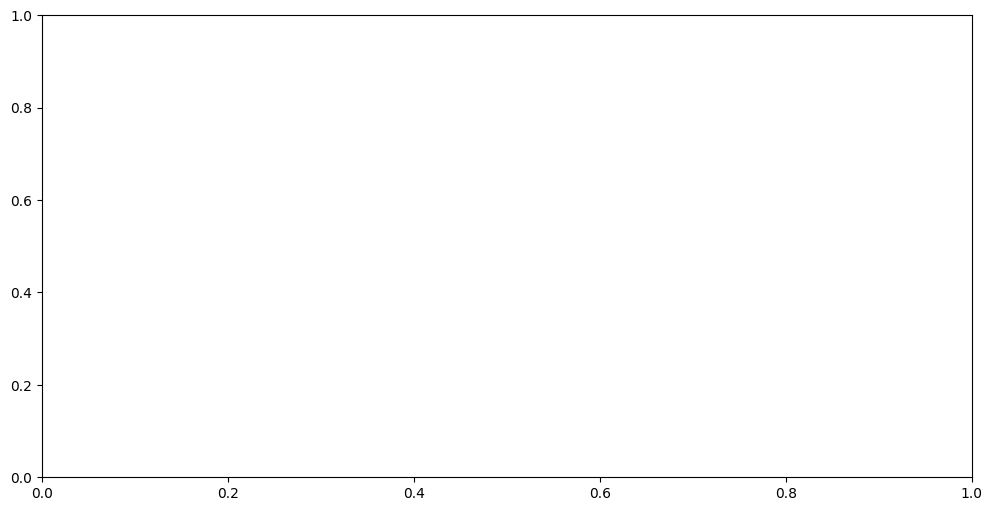

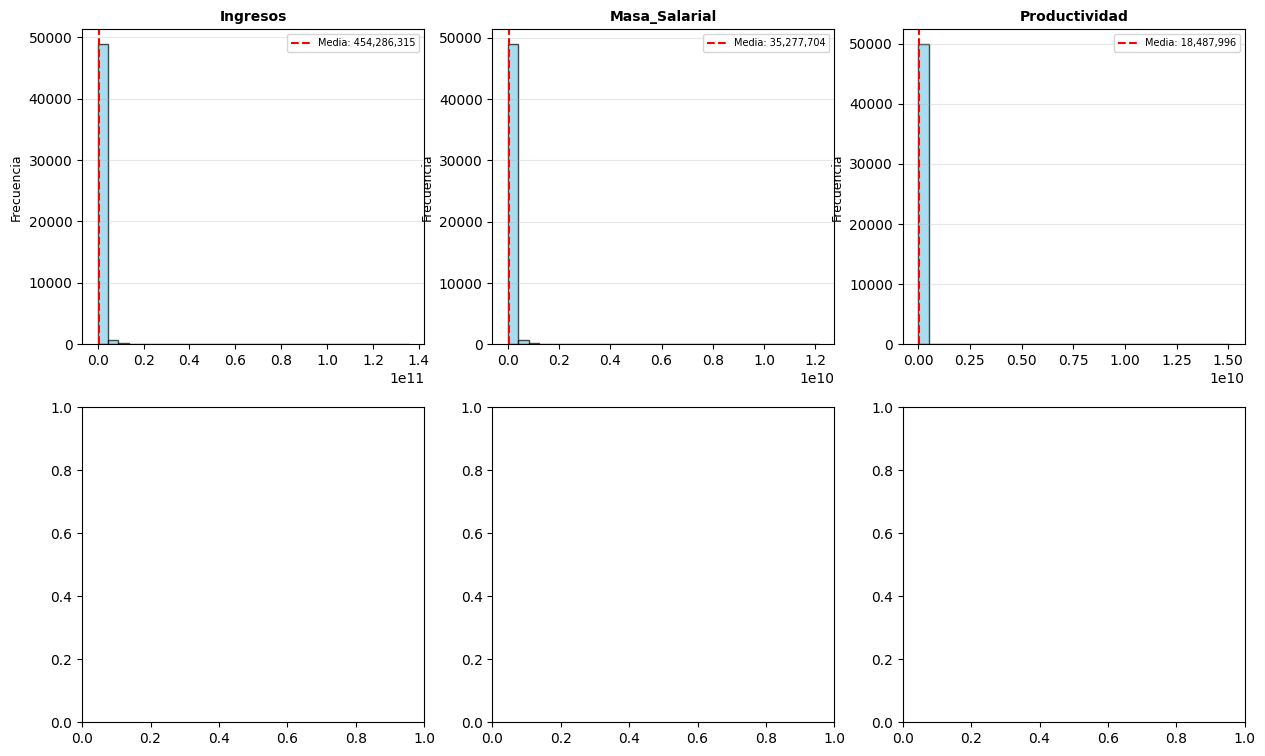

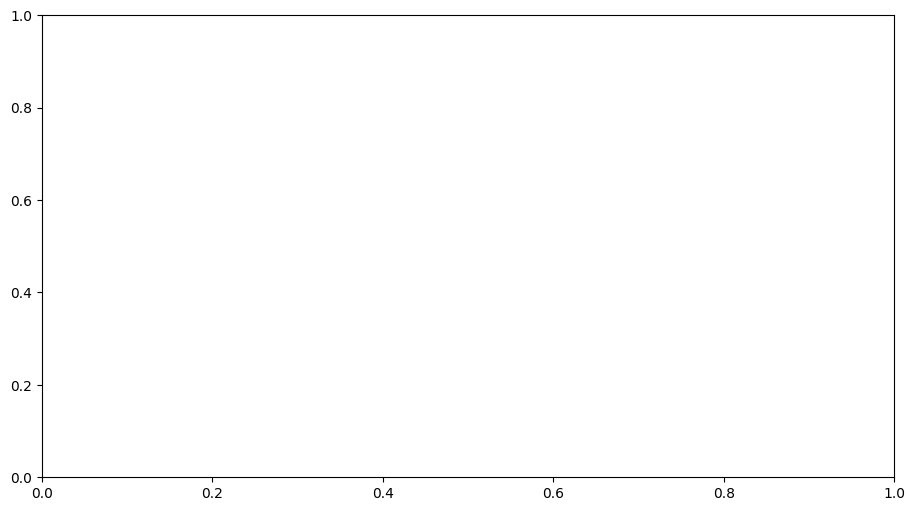

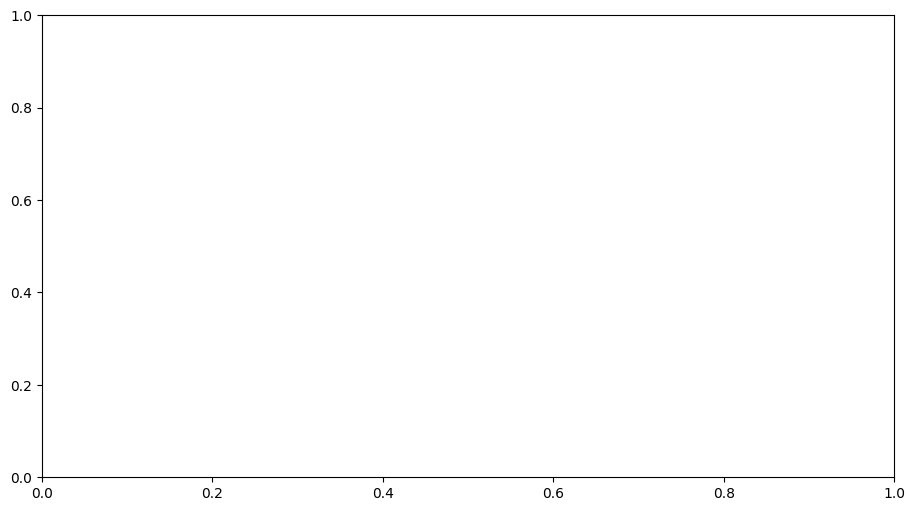

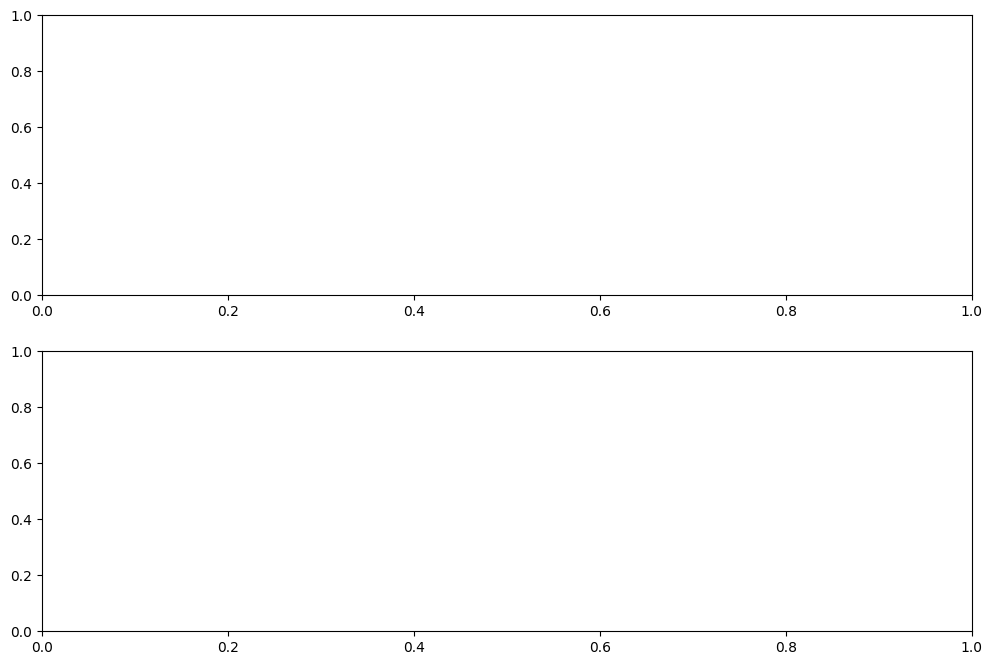

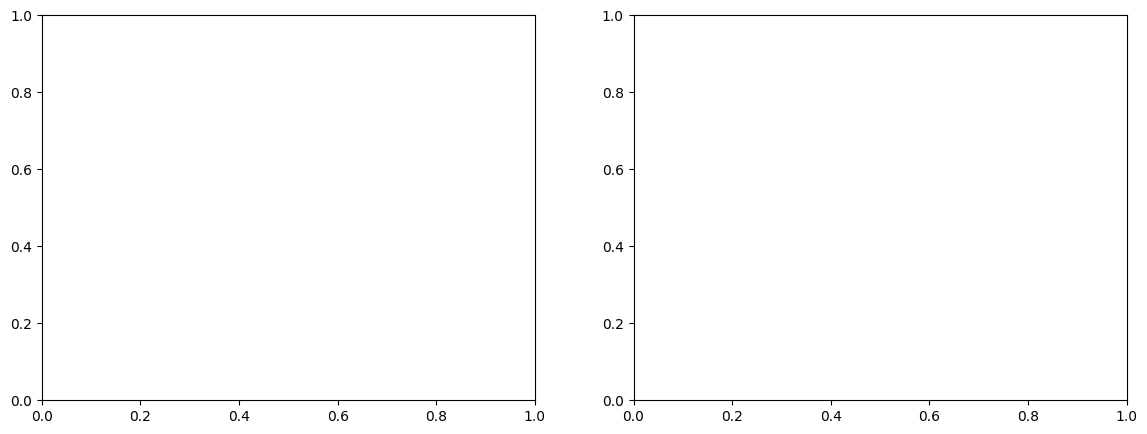

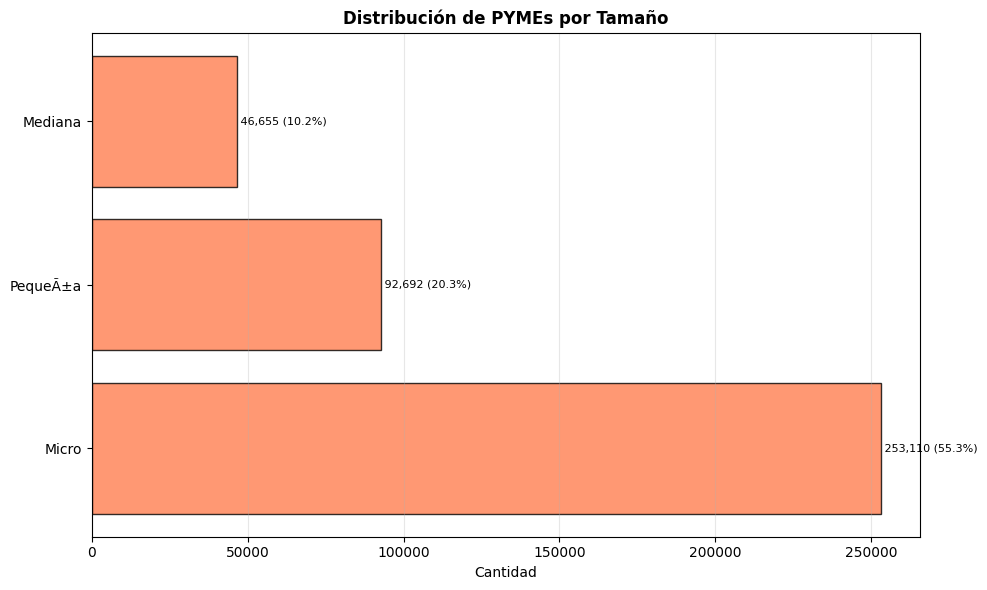

   ✓ Guardado: 02_distribucion_tamano.png

📊 [3/8] Generando: Distribución Geográfica...


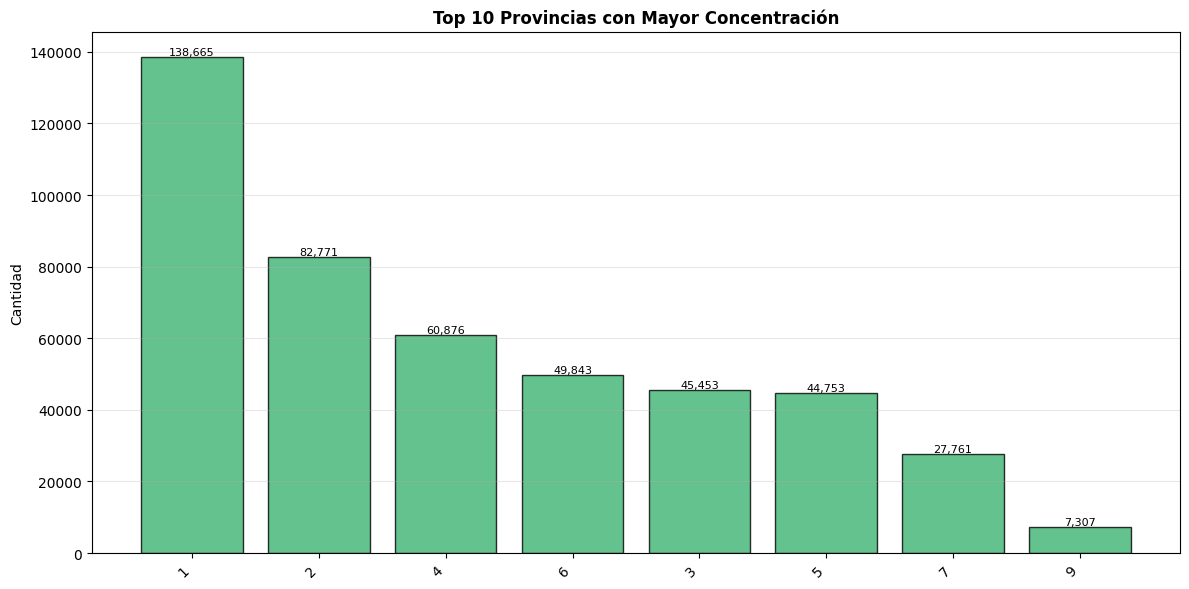

   ✓ Guardado: 03_distribucion_geografica.png

📊 [4/8] Generando: Marketing Digital vs Éxito...
   ✗ Error: 'Indicador_Éxito'

📊 [5/8] Generando: Distribuciones Numéricas...
   ✗ Error: Could not convert string '>10 aÃ±os5-10 aÃ±os>10 aÃ±os<5 aÃ±os<5 aÃ±os<5 aÃ±os>10 aÃ±os<5 aÃ±os5-10 aÃ±os>10 aÃ±os<5 aÃ±os<5 aÃ±os5-10 aÃ±os5-10 aÃ±os<5 aÃ±os>10 aÃ±os5-10 aÃ±os>10 aÃ±os>10 aÃ±os<5 aÃ±os5-10 aÃ±os5-10 aÃ±os5-10 aÃ±os<5 aÃ±os>10 aÃ±os>10 aÃ±os5-10 aÃ±os<5 aÃ±os<5 aÃ±os5-10 aÃ±os<5 aÃ±os5-10 aÃ±os>10 aÃ±os5-10 aÃ±os>10 aÃ±os5-10 aÃ±os<5 aÃ±os>10 aÃ±os<5 aÃ±os>10 aÃ±os>10 aÃ±os<5 aÃ±os5-10 aÃ±os<5 aÃ±os>10 aÃ±os5-10 aÃ±os5-10 aÃ±os<5 aÃ±os>10 aÃ±os<5 aÃ±os5-10 aÃ±os<5 aÃ±os>10 aÃ±os5-10 aÃ±os>10 aÃ±os>10 aÃ±os<5 aÃ±os<5 aÃ±os>10 aÃ±os>10 aÃ±os5-10 aÃ±os<5 aÃ±os>10 aÃ±os>10 aÃ±os<5 aÃ±os<5 aÃ±os<5 aÃ±os>10 aÃ±os<5 aÃ±os>10 aÃ±os<5 aÃ±os>10 aÃ±os<5 aÃ±os<5 aÃ±os5-10 aÃ±os>10 aÃ±os>10 aÃ±os<5 aÃ±os>10 aÃ±os5-10 aÃ±os>10 aÃ±os<5 aÃ±os>10 aÃ±os>10 aÃ±os<5 aÃ±os>10 aÃ±os>10 aÃ±os<5 aÃ±os<5 aÃ±os

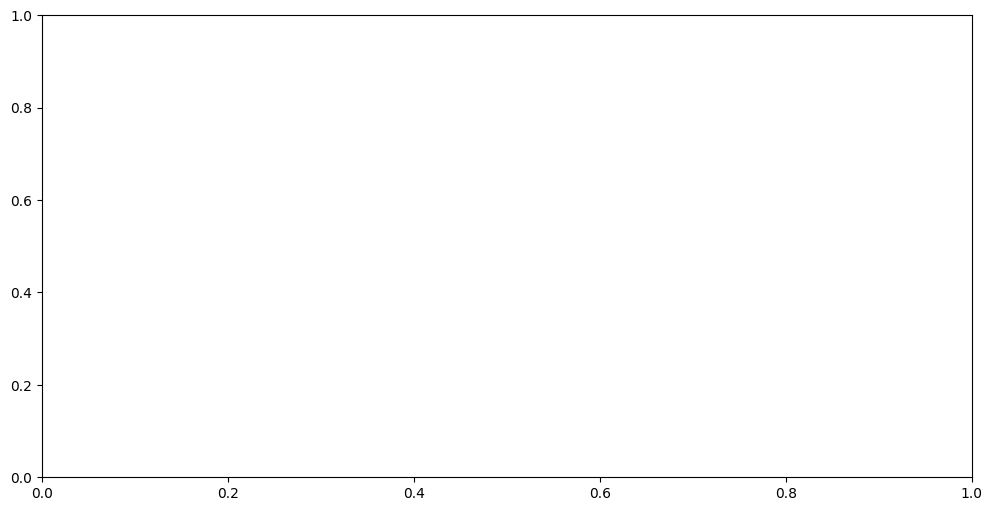

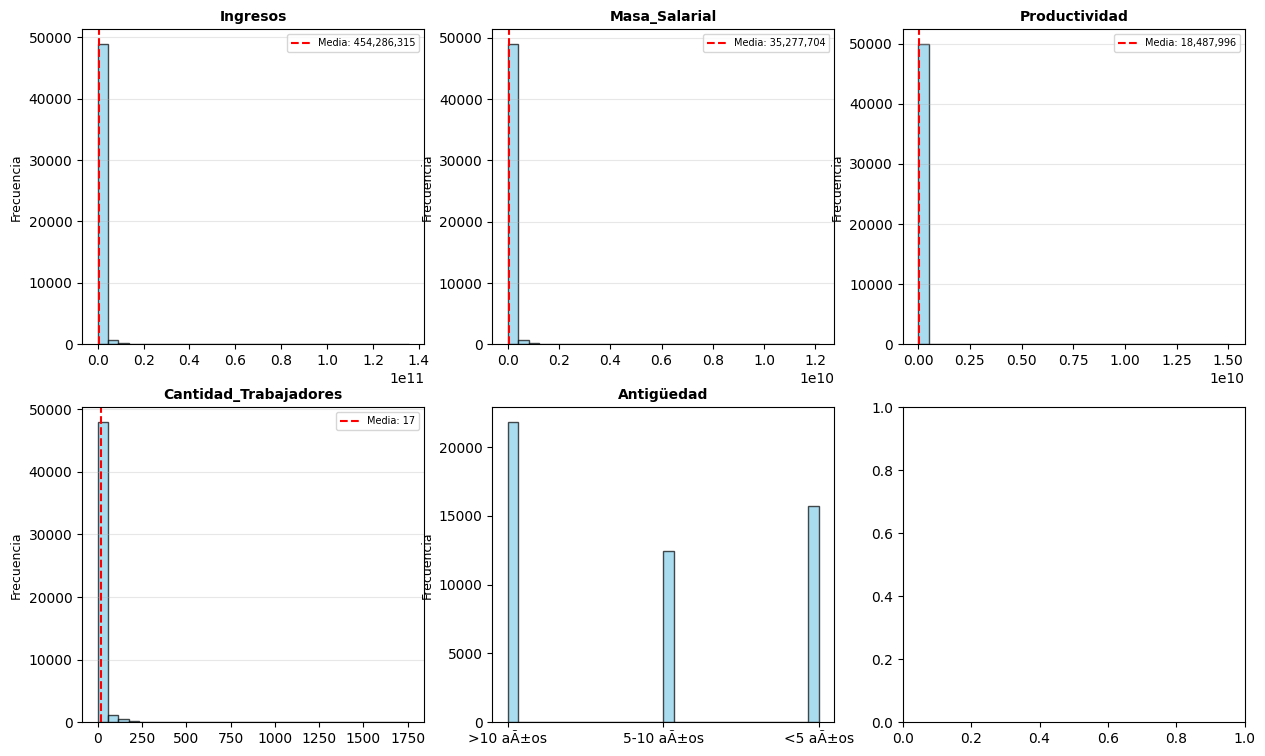

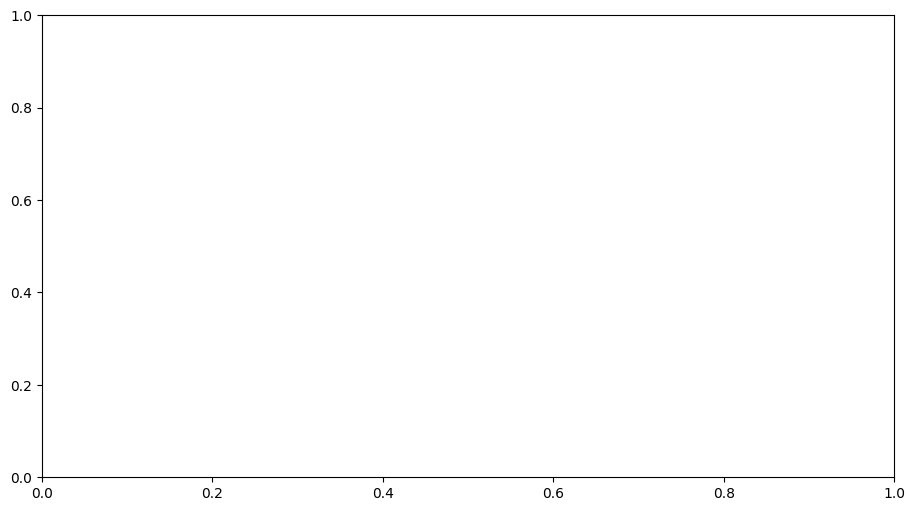

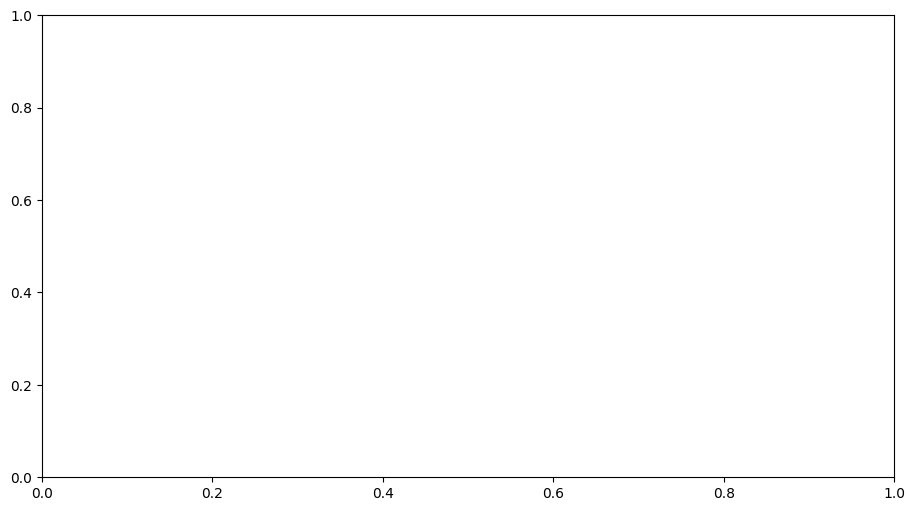

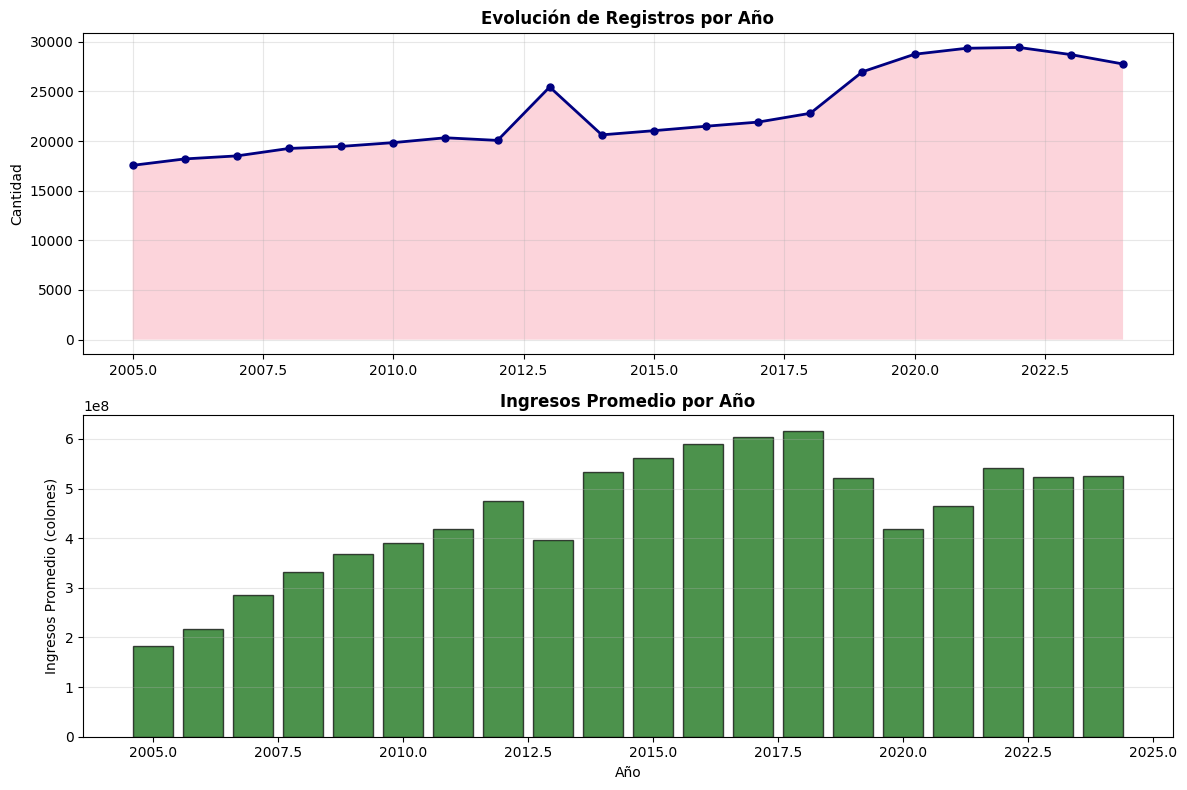

   ✓ Guardado: 08_evolucion_temporal.png

✅ PROCESO COMPLETADO
Total de gráficos generados: 8
Resolución: 150 DPI
Formato: PNG


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from IPython.display import clear_output

# ======== CONFIGURACIÓN INICIAL ========
plt.style.use('default')
sns.set_palette("husl")

print("="*60)
print("   GENERANDO VISUALIZACIONES - DATASET PYMES")
print("="*60)

# Preparar muestra
np.random.seed(42)
sample_size = min(50000, len(df))
df_sample = df.sample(n=sample_size, random_state=42)
print(f"\n✓ Usando muestra de {sample_size:,} registros")
print(f"✓ Total dataset: {len(df):,} registros\n")

# ======== 3.1 DISTRIBUCIÓN POR INDICADOR DE ÉXITO ========
print("📊 [1/8] Generando: Distribución por Indicador de Éxito...")
try:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    exito_counts = df['Indicador_Éxito'].value_counts()

    # Barras
    axes[0].bar(range(len(exito_counts)), exito_counts.values,
                color='steelblue', edgecolor='black', alpha=0.8)
    axes[0].set_xticks(range(len(exito_counts)))
    axes[0].set_xticklabels(exito_counts.index, rotation=45, ha='right')
    axes[0].set_title('Distribución de PYMEs por Indicador de Éxito',
                      fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Cantidad')
    axes[0].grid(axis='y', alpha=0.3)

    for i, v in enumerate(exito_counts.values):
        axes[0].text(i, v, f'{v:,}', ha='center', va='bottom', fontsize=8)

    # Pie
    axes[1].pie(exito_counts.values, labels=exito_counts.index,
                autopct='%1.1f%%', startangle=90)
    axes[1].set_title('Proporción por Nivel de Éxito', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.savefig('01_distribucion_exito.png', dpi=150, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    print("   ✓ Guardado: 01_distribucion_exito.png\n")
except Exception as e:
    print(f"   ✗ Error: {e}\n")

# ======== 3.2 DISTRIBUCIÓN POR TAMAÑO ========
print("📊 [2/8] Generando: Distribución por Tamaño...")
try:
    fig, ax = plt.subplots(figsize=(10, 6))
    tamano_counts = df['Tamaño'].value_counts()

    ax.barh(range(len(tamano_counts)), tamano_counts.values,
            color='coral', edgecolor='black', alpha=0.8)
    ax.set_yticks(range(len(tamano_counts)))
    ax.set_yticklabels(tamano_counts.index)
    ax.set_title('Distribución de PYMEs por Tamaño', fontsize=12, fontweight='bold')
    ax.set_xlabel('Cantidad')
    ax.grid(axis='x', alpha=0.3)

    for i, v in enumerate(tamano_counts.values):
        pct = v/len(df)*100
        ax.text(v, i, f' {v:,} ({pct:.1f}%)', va='center', fontsize=8)

    plt.tight_layout()
    plt.savefig('02_distribucion_tamano.png', dpi=150, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    print("   ✓ Guardado: 02_distribucion_tamano.png\n")
except Exception as e:
    print(f"   ✗ Error: {e}\n")

# ======== 3.3 DISTRIBUCIÓN GEOGRÁFICA ========
print("📊 [3/8] Generando: Distribución Geográfica...")
try:
    fig, ax = plt.subplots(figsize=(12, 6))
    top_provincias = df['Provincia'].value_counts().head(10)

    ax.bar(range(len(top_provincias)), top_provincias.values,
           color='mediumseagreen', edgecolor='black', alpha=0.8)
    ax.set_xticks(range(len(top_provincias)))
    ax.set_xticklabels(top_provincias.index, rotation=45, ha='right')
    ax.set_title('Top 10 Provincias con Mayor Concentración',
                 fontsize=12, fontweight='bold')
    ax.set_ylabel('Cantidad')
    ax.grid(axis='y', alpha=0.3)

    for i, v in enumerate(top_provincias.values):
        ax.text(i, v, f'{v:,}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.savefig('03_distribucion_geografica.png', dpi=150, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    print("   ✓ Guardado: 03_distribucion_geografica.png\n")
except Exception as e:
    print(f"   ✗ Error: {e}\n")

# ======== 3.4 MARKETING DIGITAL VS ÉXITO ========
print("📊 [4/8] Generando: Marketing Digital vs Éxito...")
try:
    fig, ax = plt.subplots(figsize=(12, 6))
    marketing_exito = pd.crosstab(df['Marketing_Digital'],
                                   df['Indicador_Éxito'],
                                   normalize='index') * 100

    marketing_exito.plot(kind='bar', ax=ax, stacked=False,
                         edgecolor='black', alpha=0.8)
    ax.set_title('Relación Marketing Digital e Indicador de Éxito',
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('Marketing Digital')
    ax.set_ylabel('Porcentaje (%)')
    ax.legend(title='Indicador Éxito', bbox_to_anchor=(1.05, 1))
    ax.tick_params(axis='x', rotation=0)
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig('04_marketing_vs_exito.png', dpi=150, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    print("   ✓ Guardado: 04_marketing_vs_exito.png\n")
except Exception as e:
    print(f"   ✗ Error: {e}\n")

# ======== 3.5 DISTRIBUCIONES NUMÉRICAS ========
print("📊 [5/8] Generando: Distribuciones Numéricas...")
try:
    fig, axes = plt.subplots(2, 3, figsize=(15, 9))
    variables = ['Ingresos', 'Masa_Salarial', 'Productividad',
                 'Cantidad_Trabajadores', 'Antigüedad', 'Salario_Promedio']

    for idx, var in enumerate(variables):
        ax = axes[idx // 3, idx % 3]
        data_var = df_sample[var].dropna()

        ax.hist(data_var, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        ax.set_title(f'{var}', fontsize=10, fontweight='bold')
        ax.set_ylabel('Frecuencia', fontsize=9)

        media = data_var.mean()
        ax.axvline(media, color='red', linestyle='--', linewidth=1.5,
                   label=f'Media: {media:,.0f}')
        ax.legend(fontsize=7)
        ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig('05_distribuciones_numericas.png', dpi=150, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    print("   ✓ Guardado: 05_distribuciones_numericas.png\n")
except Exception as e:
    print(f"   ✗ Error: {e}\n")

# ======== 3.6 BOXPLOTS INGRESOS ========
print("📊 [6/8] Generando: Boxplots de Ingresos...")
try:
    fig, ax = plt.subplots(figsize=(11, 6))

    # Muestra reducida para boxplot
    df_box = df_sample.sample(n=min(5000, len(df_sample)), random_state=42)

    sns.boxplot(data=df_box, x='Indicador_Éxito', y='Ingresos',
                ax=ax, palette='Set2', showfliers=False)
    ax.set_title('Distribución de Ingresos según Indicador de Éxito',
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('Indicador de Éxito')
    ax.set_ylabel('Ingresos (colones)')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig('06_ingresos_por_exito.png', dpi=150, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    print("   ✓ Guardado: 06_ingresos_por_exito.png\n")
except Exception as e:
    print(f"   ✗ Error: {e}\n")

# ======== 3.7 ANTIGÜEDAD VS ÉXITO ========
print("📊 [7/8] Generando: Antigüedad vs Éxito...")
try:
    fig, ax = plt.subplots(figsize=(11, 6))
    antiguedad_exito = df.groupby('Indicador_Éxito')['Antigüedad'].mean().sort_values()

    ax.barh(range(len(antiguedad_exito)), antiguedad_exito.values,
            color='darkorange', edgecolor='black', alpha=0.8)
    ax.set_yticks(range(len(antiguedad_exito)))
    ax.set_yticklabels(antiguedad_exito.index)
    ax.set_title('Antigüedad Promedio por Indicador de Éxito',
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('Antigüedad Promedio (años)')
    ax.grid(axis='x', alpha=0.3)

    for i, v in enumerate(antiguedad_exito.values):
        ax.text(v, i, f' {v:.1f} años', va='center', fontsize=8)

    plt.tight_layout()
    plt.savefig('07_antiguedad_vs_exito.png', dpi=150, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    print("   ✓ Guardado: 07_antiguedad_vs_exito.png\n")
except Exception as e:
    print(f"   ✗ Error: {e}\n")

# ======== 3.8 EVOLUCIÓN TEMPORAL ========
print("📊 [8/8] Generando: Evolución Temporal...")
try:
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))

    pymes_por_ano = df.groupby('Año').size()
    axes[0].plot(pymes_por_ano.index, pymes_por_ano.values,
                 marker='o', linewidth=2, markersize=5, color='navy')
    axes[0].fill_between(pymes_por_ano.index, pymes_por_ano.values, alpha=0.3)
    axes[0].set_title('Evolución de Registros por Año', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Cantidad')
    axes[0].grid(True, alpha=0.3)

    ingresos_por_ano = df.groupby('Año')['Ingresos'].mean()
    axes[1].bar(ingresos_por_ano.index, ingresos_por_ano.values,
                color='darkgreen', edgecolor='black', alpha=0.7)
    axes[1].set_title('Ingresos Promedio por Año', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Año')
    axes[1].set_ylabel('Ingresos Promedio (colones)')
    axes[1].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig('08_evolucion_temporal.png', dpi=150, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    print("   ✓ Guardado: 08_evolucion_temporal.png\n")
except Exception as e:
    print(f"   ✗ Error: {e}\n")

# ======== RESUMEN FINAL ========
print("="*60)
print("✅ PROCESO COMPLETADO")
print("="*60)
print(f"Total de gráficos generados: 8")
print(f"Resolución: 150 DPI")
print(f"Formato: PNG")
print("="*60)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 4. -----RELACIONES------

print("ANÁLISIS DE CORRELACIONES")

columnas_numericas = ['Año', 'Cantidad_Trabajadores', 'Masa_Salarial',
                      'Ingresos', 'Exportaciones', 'Importaciones',
                      'Antigüedad', 'Productividad', 'Intensidad_Exportadora',
                      'Salario_Promedio']

correlation_matrix = df[columnas_numericas].corr()

print("\n  → Gráfico 9: Matriz de Correlación...")
fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f',
            cmap='coolwarm', center=0, square=True, linewidths=1,
            cbar_kws={"shrink": 0.8}, ax=ax, annot_kws={"size": 9})
ax.set_title('Matriz de Correlación - Variables Numéricas', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('09_matriz_correlacion.png', dpi=200, bbox_inches='tight')
plt.close()
print("  ✓ Guardado: 09_matriz_correlacion.png")

print("\n✓ Correlaciones más fuertes (|r| > 0.5):")
correlaciones_fuertes = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.5:
            correlaciones_fuertes.append({
                'Variable 1': correlation_matrix.columns[i],
                'Variable 2': correlation_matrix.columns[j],
                'Correlación': corr_value
            })

if len(correlaciones_fuertes) > 0:
    df_corr_fuertes = pd.DataFrame(correlaciones_fuertes).sort_values('Correlación', key=abs, ascending=False)
    print(df_corr_fuertes.to_string(index=False))
else:
    print("  No se encontraron correlaciones superiores a 0.5")

# Scatter plot Productividad vs Ingresos (CON MUESTRA PEQUEÑA)
print("\n  → Gráfico 10: Productividad vs Ingresos...")
fig, ax = plt.subplots(figsize=(10, 6))
sample_scatter = df_sample.sample(n=min(5000, len(df_sample)), random_state=42)  # SOLO 5000 PUNTOS
ax.scatter(sample_scatter['Productividad'], sample_scatter['Ingresos'], alpha=0.4, s=20)
ax.set_title('Relación entre Productividad e Ingresos', fontsize=13, fontweight='bold')
ax.set_xlabel('Productividad (Ingresos por Trabajador)', fontsize=10)
ax.set_ylabel('Ingresos Totales', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('10_productividad_vs_ingresos.png', dpi=200, bbox_inches='tight')
plt.close()
print("  ✓ Guardado: 10_productividad_vs_ingresos.png")

# Test Chi-cuadrado
print("\n" + "-"*80)
print("TEST CHI-CUADRADO: Marketing Digital vs Indicador de Éxito")
print("-"*80)

contingency_table = pd.crosstab(df['Marketing_Digital'], df['Indicador_Éxito'])
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print(f"\nTabla de contingencia:")
print(contingency_table.to_string())
print(f"\nEstadístico Chi-cuadrado: {chi2:.4f}")
print(f"Valor p: {p_value:.4f}")
print(f"Grados de libertad: {dof}")

if p_value < 0.05:
    print("\n✓ Conclusión: Existe relación estadísticamente significativa (p < 0.05)")
else:
    print("\n✓ Conclusión: No hay evidencia suficiente (p >= 0.05)")


In [ ]:
# 5.-----VALORES ATÍPICOS-----

def detectar_outliers_iqr(data, columna):
    Q1 = data[columna].quantile(0.25)
    Q3 = data[columna].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[columna] < lower_bound) | (data[columna] > upper_bound)]

    return {
        'Variable': columna,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Límite Inferior': lower_bound,
        'Límite Superior': upper_bound,
        'Cantidad Outliers': len(outliers),
        'Porcentaje': (len(outliers) / len(data)) * 100
    }

variables_analizar = ['Ingresos', 'Masa_Salarial', 'Productividad',
                      'Cantidad_Trabajadores', 'Salario_Promedio']

outliers_summary = []
for var in variables_analizar:
    resultado = detectar_outliers_iqr(df, var)
    outliers_summary.append(resultado)

df_outliers = pd.DataFrame(outliers_summary)
print("\n✓ Resumen de Valores Atípicos (Método IQR):")
print(df_outliers.to_string(index=False))

print("\n  → Gráfico 11: Detección de Outliers...")
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
for idx, var in enumerate(variables_analizar + ['Antigüedad']):
    ax = axes[idx // 3, idx % 3]
    bp = ax.boxplot(df[var].dropna(), vert=True, patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][0].set_alpha(0.7)
    ax.set_title(f'Outliers: {var}', fontsize=11, fontweight='bold')
    ax.set_ylabel(var, fontsize=9)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('11_deteccion_outliers.png', dpi=200, bbox_inches='tight')
plt.close()
print("  ✓ Guardado: 11_deteccion_outliers.png")

print("\n✓ Análisis de casos extremos:")
for var in ['Ingresos', 'Productividad']:
    print(f"\n{var} - Top 5:")
    top_5 = df.nlargest(5, var)[['Tamaño', 'Clase_CIIU', 'Provincia', var, 'Indicador_Éxito']]
    print(top_5.to_string(index=False))

In [ ]:
# ----6. ANÁLISIS ESPECÍFICOS SEGÚN OBJETIVOS DEL PROYECTO----


# Objetivo 1
print("\nObjetivo 1: Análisis Regional")
print("-"*80)
exito_por_provincia = pd.crosstab(df['Provincia'], df['Indicador_Éxito'], normalize='index') * 100
top_provincias_list = df['Provincia'].value_counts().head(10).index
print("\nPorcentaje de Éxito por Provincia (Top 10):")
print(exito_por_provincia.loc[top_provincias_list].round(2).to_string())

# Objetivo 2
print("\n\nObjetivo 2: Marketing Digital")
print("-"*80)
marketing_stats = df.groupby('Marketing_Digital').agg({
    'Ingresos': ['mean', 'median'],
    'Productividad': ['mean', 'median']
}).round(2)
print("\nEstadísticas por Marketing Digital:")
print(marketing_stats.to_string())

# Objetivo 3
print("\n\nObjetivo 3: Antigüedad")
print("-"*80)
df['Grupo_Antigüedad'] = pd.cut(df['Antigüedad'],
                                 bins=[0, 5, 10, float('inf')],
                                 labels=['Menos de 5 años', '5-10 años', 'Más de 10 años'])

for grupo in ['Menos de 5 años', '5-10 años', 'Más de 10 años']:
    grupo_data = df[df['Grupo_Antigüedad'] == grupo]
    if len(grupo_data) > 0:
        print(f"\n{grupo}:")
        print(f"  Total: {len(grupo_data):,}")
        print(f"  Ingresos promedio: {grupo_data['Ingresos'].mean():,.2f}")
        print(f"  Distribución Éxito (%):")
        print(grupo_data['Indicador_Éxito'].value_counts(normalize=True).multiply(100).round(2).to_string())

print("\n  → Gráfico 12: Análisis Objetivos...")
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

antiguedad_exito_pct = pd.crosstab(df['Grupo_Antigüedad'], df['Indicador_Éxito'], normalize='index') * 100
antiguedad_exito_pct.plot(kind='bar', ax=axes[0], stacked=True, edgecolor='black')
axes[0].set_title('Éxito por Antigüedad', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Grupo de Antigüedad', fontsize=10)
axes[0].set_ylabel('Porcentaje (%)', fontsize=10)
axes[0].legend(title='Éxito', bbox_to_anchor=(1.05, 1), fontsize=8)
axes[0].tick_params(axis='x', rotation=45, labelsize=9)
axes[0].grid(axis='y', alpha=0.3)

marketing_comparison = df.groupby(['Marketing_Digital', 'Indicador_Éxito']).size().unstack(fill_value=0)
marketing_comparison.plot(kind='bar', ax=axes[1], edgecolor='black')
axes[1].set_title('Éxito según Marketing', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Marketing Digital', fontsize=10)
axes[1].set_ylabel('Cantidad', fontsize=10)
axes[1].legend(title='Éxito', bbox_to_anchor=(1.05, 1), fontsize=8)
axes[1].tick_params(axis='x', rotation=0, labelsize=9)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('12_analisis_objetivos.png', dpi=200, bbox_inches='tight')
plt.close()
print("  ✓ Guardado: 12_analisis_objetivos.png")

print("\n" + "="*80)
print("✓✓✓ ANÁLISIS COMPLETADO EXITOSAMENTE ✓✓✓")
print("="*80)
print("\n12 gráficos generados correctamente")